# Model for the README file

This notebook is used to generate the plots in the `README` file,
and check that the code actually works.

The model is a simple Lotka-Volterra (predator-prey) model. 

$$ dx/dt = ax - bxy\,,\quad dy/dt = cxy - dy $$

with initial conditions

$$ x(0) = x_0\,,\quad y(0) = y_0 $$

The observations have a log-normal distribution with scale parameter $\sigma$.
The parameters $a, b, c, d$ have random effects and the parameters $x_0$ and $y_0$ 
are constants. The scale $\sigma$ is shared between experiments.

### Define the model and inspect the Stan code


In [1]:
import hboms
import numpy as np

ode_model = """
ddt_x = a*x - b*x*y;
ddt_y = c*x*y - d*y;
"""

init = """
x_0 = x0;
y_0 = y0;
"""

params = [
    hboms.Parameter("a", 0.8, "random", scale=0.2), # name, initial guess, type
    hboms.Parameter("b", 0.7, "random", scale=0.2),
    hboms.Parameter("c", 0.6, "random", scale=0.2),
    hboms.Parameter("d", 0.4, "random", scale=0.2),
    hboms.Parameter("x0", 1.0, "const"), # initial conditions
    hboms.Parameter("y0", 1.0, "const"),
    hboms.Parameter("sigma", 0.1, "fixed") # measurement error
]

state = [hboms.Variable("x"), hboms.Variable("y")]

obs = [hboms.Observation("X"), hboms.Observation("Y")]

dists = [
    hboms.StanDist("lognormal", "X", params=["log(x)", "sigma"]),
    hboms.StanDist("lognormal", "Y", params=["log(y)", "sigma"])
]

hbm = hboms.HbomsModel(
    name = "lotka",
    odes = ode_model,
    init = init,
    params = params,
    state = state,
    obs = obs,
    dists = dists
)

hboms.utilities.show_stan_model(hbm.model_code, line_numbers=True)



11:12:43 - cmdstanpy - INFO - compiling stan file /home/chris/Repositories/hboms/notebooks/lotka.stan to exe file /home/chris/Repositories/hboms/notebooks/lotka
11:13:12 - cmdstanpy - INFO - compiled model executable: /home/chris/Repositories/hboms/notebooks/lotka


### Simulate data with the HBOMS model

We have to specify for each unit/experiment at which times we want observations.

In [2]:
R = 12

data = {
    "Time" : [list(np.linspace(1, 30, 15)) for _ in range(R)]
}

sims = hbm.simulate(data=data, num_simulations=10)

data, sim_params = sims[0]

11:13:13 - cmdstanpy - INFO - compiling stan file /home/chris/Repositories/hboms/notebooks/lotka_simulator.stan to exe file /home/chris/Repositories/hboms/notebooks/lotka_simulator
11:13:33 - cmdstanpy - INFO - compiled model executable: /home/chris/Repositories/hboms/notebooks/lotka_simulator
11:13:33 - cmdstanpy - INFO - CmdStan start processing
11:13:33 - cmdstanpy - INFO - Chain [1] start processing
11:13:33 - cmdstanpy - INFO - Chain [1] done processing


### Look at the initial parameter guess.

It helps if the trajectories based on the initial parameter guess are not too far off. 
Otherwise the MHC sampler gets stuck in local optima.

11:13:33 - cmdstanpy - INFO - CmdStan start processing
11:13:33 - cmdstanpy - INFO - Chain [1] start processing
11:13:33 - cmdstanpy - INFO - Chain [1] done processing


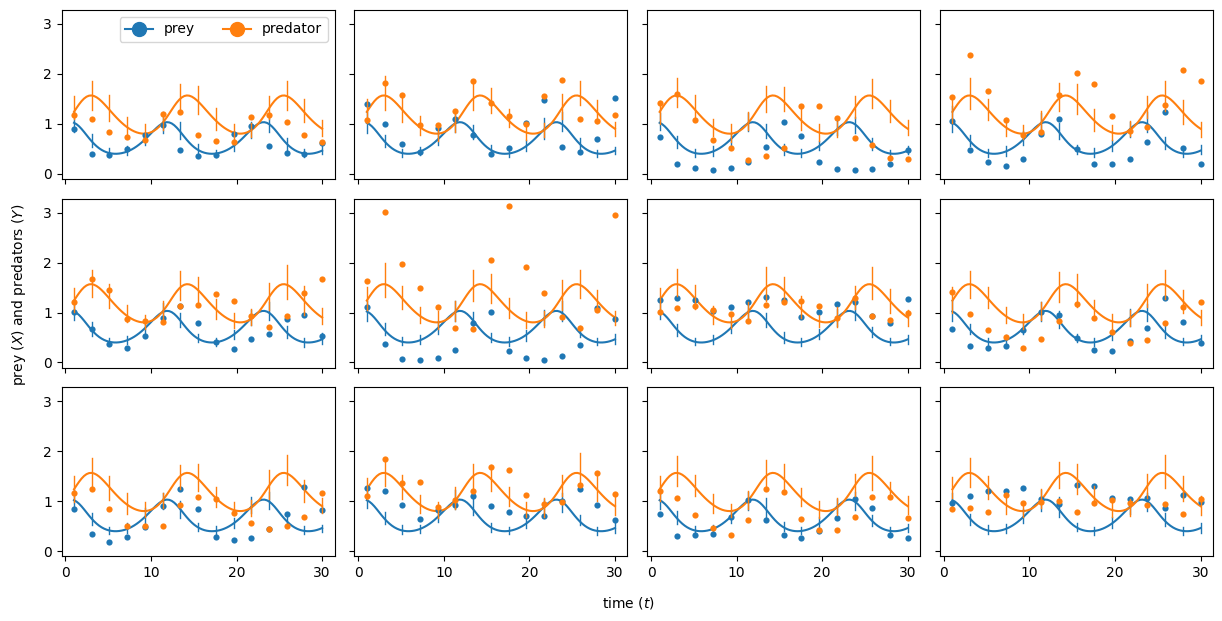

In [3]:
from matplotlib.lines import Line2D

fig = hbm.init_check(data)

fig.text(0, 0.5, "prey ($X$) and predators ($Y$)", rotation=90, va='center', ha='right')
fig.text(0.5, 0, "time ($t$)", va='top', ha='center')

point1 = Line2D([0], [0], label='prey', marker='o', markersize=10, color='tab:blue')
point2 = Line2D([0], [0], label='predator', marker='o', markersize=10, color='tab:orange')
axs = fig.get_axes()
axs[0].legend(handles=[point1, point2], ncol=2)

fig.tight_layout()

fig.savefig("../figures/init_check.png", dpi=200, bbox_inches='tight')

### Sample from the posterior distribution

In [4]:
hbm.sample(
    data,
    iter_warmup=200,
    iter_sampling=200,
    step_size=0.01,
    refresh=1,
    chains=1,
    threads_per_chain=12
)

11:13:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

11:14:06 - cmdstanpy - INFO - CmdStan done processing.


### Look at the posterior predictive checks

a.k.a. model fit

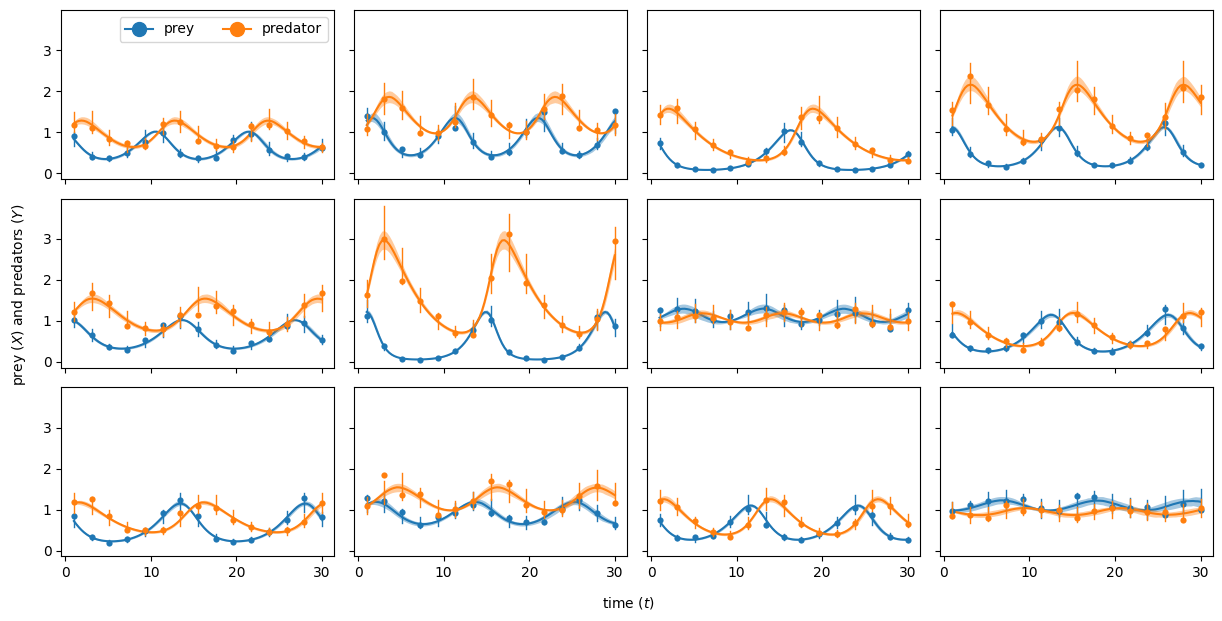

In [5]:
fig = hbm.post_pred_check(data)

fig.text(0, 0.5, "prey ($X$) and predators ($Y$)", rotation=90, va='center', ha='right')
fig.text(0.5, 0, "time ($t$)", va='top', ha='center')

point1 = Line2D([0], [0], label='prey', marker='o', markersize=10, color='tab:blue')
point2 = Line2D([0], [0], label='predator', marker='o', markersize=10, color='tab:orange')
axs = fig.get_axes()
axs[0].legend(handles=[point1, point2], ncol=2)

fig.tight_layout()

fig.savefig("../figures/post_pred_check.png", dpi=200, bbox_inches='tight')